In [1]:
try:
    from calculations import *
    import os.path
    import os
    from pathlib import Path
    from itertools import groupby
    import numpy as np
    from beyond.dates import Date, timedelta
    from beyond.io.tle import Tle
    from beyond.frames import create_station
    from beyond.config import config
    import csv
except:
    import pip
    pip.main(['install','beyond'])

## Configuration

In [2]:
gps = np.array([51.03594,5.72767,34]) #Latitude, Longitude, Height in meters
tle_location = r'tle' #TLE files
output_location = r'instructions' #Output location for orbits
timestep = 15 #How many seconds per calculation step?
iterations = 2 #How many passes?
#minimum_angle = None #FIX
minimum_angle = 5
multiverbose = True
terminal_output = False
verbose = True #Extra info about pass
file_output = True

## Initialization

In [3]:
#Create tracking station
station = create_station('Radio Telescope', gps)

#Create paths to file locations
cwd = Path.cwd()
instructions_src = (cwd / output_location).resolve()
tle_src = (cwd / tle_location).resolve()
if not os.path.isdir(tle_src): raise ValueError("Error: %s is not a valid directory"%(tle_src))
elif not os.path.isdir(instructions_src): raise ValueError("Error: %s is not a valid directory"%(instructions_src))

#Create output folders
for file in os.listdir(tle_src):
    if not os.path.isdir((instructions_src / file[0:-4]).resolve()):
        os.mkdir((instructions_src / file[0:-4]).resolve())
        #print(file[0:-4])

#Create dictionary with tle files
tle_files={}
for tle_file in os.listdir(tle_src):
    tle_files[tle_file]=Tle(parse_tle((tle_src / tle_file).resolve())).orbit() 

## View orbital parameters

In [4]:
for file in tle_files:
    print(file)
    print(repr(tle_files[file]))

iss.tle

Orbit =
  date = 2021-11-29T11:53:28.588128 UTC
  form = tle
  frame = TEME
  propag = Sgp4
  coord =
    i = 0.9013578388999515
    Ω = 4.2820099854646605
    e = 0.0004305
    ω = 4.524794011063332
    M = 4.778152986599836
    n = 0.0011262493475096662

kosen-1.tle

Orbit =
  date = 2021-12-21T03:50:31.765632 UTC
  form = tle
  frame = TEME
  propag = Sgp4
  coord =
    i = 1.70271878363614
    Ω = 0.9368752891780362
    e = 0.0025033
    ω = 1.835990379989175
    M = 4.454169262881381
    n = 0.0010929226614158443



## Calculation

In [5]:
if terminal_output:
    print("          Time     Elev    Azimuth  Distance Radial Velocity")
    print("=========================================================")
    #azimuths, elevations = [[]] * iterations, [[]] * iterations
azimuths, elevations = [],[]
azimuth, elevation, iteration, maximum_angle = 0, 0, 0, 0
first, write = True, False

for file in tle_files:
    if multiverbose: print(file)
    iteration = 0
    for orbit in station.visibility(tle_files[file], start=Date.now(), stop=timedelta(days=140), step=timedelta(seconds=timestep), events=True):
        #Check if partial orbit
        if first and not orbit.event:    
            break

        #Angle conversion from radians to degrees
        elevation = np.degrees(orbit.phi)
        azimuth = np.degrees(-orbit.theta) % 360

        azimuths.append(azimuth)
        elevations.append(90 - elevation)

        if elevation > maximum_angle: maximum_angle = elevation

        r = orbit.r / 1000 #Convert meters to kilometers

        try:
            event = event_parser(orbit.event)   
        except:
            event = ""

        if first:    
            current_src = (instructions_src / file[0:-4]).resolve()
            filename = str(orbit.date).replace(":", "-")[0:-11] + ".csv"
            current_file = (current_src / filename).resolve()

            if os.path.exists(current_file):
                write = False

            if file_output:
                f = open(current_file, 'w', encoding='UTF8', newline='')
                csv_output = csv.writer(f)
                csv_output.writerow(['Time (UTC+0)','Elevation (in ° normal)','Azimuth (in ° N)'])
                write = True

            first = False

        if write:
            csv_output.writerow([str(orbit.date)[0:-11],round(elevation,2),round(azimuth,2)])

        if terminal_output: print("{event:7} {orb.date:%H:%M:%S} {elev:7.1f} {azim:7.1f} {r:10.1f} {orb.r_dot:10.1f}".format(orb=orbit, r=r, azim=azimuth, elev=elevation, event=event if orbit.event is not None else ""))

        if orbit.event and orbit.event.info.startswith("LOS"):
            first = True
            write = False

            #Close csv file
            try:
                f.close()
            except Exception as e:
                print(e)


            if terminal_output: print()
            
            #Dividers for list seperation
            azimuths.append("|")
            elevations.append("|")
            
            #Check for minimum angle
            if minimum_angle and round(maximum_angle) < minimum_angle:
                os.remove(current_file)
                maximum_angle = 0
                
            else:
                if verbose or multiverbose:
                    print("Max = %s, Pass = %s"%(maximum_angle,iteration))

                iteration += 1
                maximum_angle = 0

                #Stop after n iterations 
                if iteration == iterations:
                    #Shutdown orbit finder
                    iteration = 0
                    break

            

#Out of loop; list seperation
try:
    azimuths = [list(g) for k,g in groupby(azimuths, key=lambda x: x != '|') if k]
    elevations = [list(g) for k,g in groupby(elevations, key=lambda x: x != '|') if k]
except:
    print("error with splitting lists")

iss.tle
Max = 8.785418684926187, Pass = 0
Max = 37.306038394521714, Pass = 1
kosen-1.tle
Max = 34.90285214797211, Pass = 0
Max = 25.451336005228605, Pass = 1


## Visualization

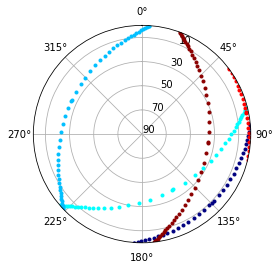

In [6]:
plot_polar(azimuths,elevations)